# CHESS OUTCOME PREDICTION - MODEL TRAINING

**Goal**: train a binary classifier (*white vs. black*, draws removed) using token sequences of the opening plus optional Elo features.

**Inputs**
- Arrays: `X_train_seq`, `X_val_seq`, `X_test_seq` (padded token IDs), `y_*`.
- *(Optional)* numeric features: `X_*_num` (e.g., `elo_diff`, `elo_avg`).
- *(Optional)* `ds_train`, `ds_val`, `ds_test` (`tf.data`); otherwise they are built here.
- Config/metadata: `SEQ_LEN`, `VOCAB_SIZE`, `NUM_NUMERIC`, `BATCH`, `EPOCHS`, `SEED`.

**Model (two-branch)**
- **Sequence branch**: `Embedding(VOCAB_SIZE, 128, mask_zero=True)` -> `Bidirectional(GRU(128, return_sequences=True))` -> `GlobalMaxPool1D` -> `Dropout(0.2)`.
- **Numeric branch** *(if present)*: `LayerNormalization` -> `Dense(64, relu)` -> `Dropout(0.2)`.
- **Head**: `Concatenate` -> `Dense(128, relu)` -> `Dropout(0.2)` -> `Dense(1, sigmoid)`.

**Training**
- Optimizer: `Adam` (clipnorm=1.0, lr=1e-3).  
- Loss/metrics: `binary_crossentropy`, `accuracy`, `AUC`.
- Callbacks: `EarlyStopping(patience=7, restore_best_weights=True)`,  
  `ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-5)`,  
  `ModelCheckpoint(save_best_only=True, monitor="val_loss")`.
- *(Optional)* `class_weight` for balance.  
- Reproducibility: fixed `SEED`.

**Evaluation**
- Report accuracy and macro-F1 on val and test (default threshold=0.5).
- Grid-search the best probability threshold on the validation set; re-report test metrics at that threshold.
- Show `classification_report` and confusion matrix.

**Outputs (in `results/`)**
- `best_seq_model.keras` - best weights by `val_loss`.
- `label_mapping.json` - `{black: 0, white: 1}`.
- `class_weights.json` - *(if used)*.
- `seq_report.json` - metrics (val/test), confusion matrices, chosen threshold.

In [1]:
# ==============================================
# 1. Imports & Paths
# ==============================================
from pathlib import Path
import json
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)

import tensorflow as tf

# ----------------------------------------------
# 1.1 Config
# ----------------------------------------------
SEED = 42
CUTOFF_FULL_MOVES = 30
CUTOFF_PLIES = CUTOFF_FULL_MOVES * 2
MOVE_COL = f"moves_first{CUTOFF_FULL_MOVES}_san"

# ----------------------------------------------
# 1.2 Reproducibility
# ----------------------------------------------
np.random.seed(SEED)
tf.random.set_seed(SEED)
gpus = tf.config.list_physical_devices("GPU")
for g in gpus:
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass

# ----------------------------------------------
# 1.3 Paths
# ----------------------------------------------
NB_DIR = Path.cwd()
DATA_DIR = (NB_DIR / "../data").resolve()
RESULTS_DIR = (NB_DIR / "../results").resolve()
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
ELO_FEATS = ["elo_diff", "elo_avg", "white_elo", "black_elo"]

CLEAN_CSV = DATA_DIR / "chess_games_clean.csv"
META_JSON = DATA_DIR / "chess_games_clean_meta.json"
BOARDS_NPZ = DATA_DIR / "chess_boards_8x8xC.npz"

globals().setdefault("BATCH", 512)
globals().setdefault("EPOCHS", 40)


print("Data:", CLEAN_CSV)
print("Meta:", META_JSON)
print(f"Cutoff: {CUTOFF_FULL_MOVES} moves ({CUTOFF_PLIES} plies)")
print("Results dir:", RESULTS_DIR)

Data: E:\Github Projects\chess-outcome-prediction\data\chess_games_clean.csv
Meta: E:\Github Projects\chess-outcome-prediction\data\chess_games_clean_meta.json
Cutoff: 30 moves (60 plies)
Results dir: E:\Github Projects\chess-outcome-prediction\results


In [2]:
# ==============================================
# 2. Load, Tokenise, Split
# ==============================================
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import json

# ----------------------------------------------
# 2.1 Load
# ----------------------------------------------
df = pd.read_csv(CLEAN_CSV)
expected = {MOVE_COL, "plies_processed", "cutoff_reached", "target"}
missing = sorted(list(expected - set(df.columns)))
assert not missing, f"Missing columns: {missing}"
df = df.dropna(subset=[MOVE_COL, "target"]).reset_index(drop=True)
df = df[df[MOVE_COL].str.len() > 0].reset_index(drop=True)

# ----------------------------------------------
# 2.2 Labels (binary: white vs black only)
# ----------------------------------------------
# Keep only non-draw games (should already be true after your 02 notebook change,
# but this guards against stale CSVs)
df = df[df["target"].isin(["black", "white"])].reset_index(drop=True)

CLASS_ORDER = ["black", "white"]   # id: 0 = black, 1 = white (keep this stable)
label_to_id = {c:i for i,c in enumerate(CLASS_ORDER)}
id_to_label = {i:c for c,i in label_to_id.items()}

y = df["target"].map(label_to_id).astype("int32")
assert set(np.unique(y)) == {0,1}, f"Unexpected labels in y: {set(np.unique(y))}"

# ----------------------------------------------
# 2.3 Tokenise
# ----------------------------------------------
def to_tokens(s):
    return str(s).split()

tokens = df[MOVE_COL].apply(to_tokens)

# ----------------------------------------------
# 2.4 Split
# ----------------------------------------------
X_tmp, X_test_tok, y_tmp, y_test = train_test_split(
    tokens, y, test_size=0.15, random_state=SEED, stratify=y
)
X_train_tok, X_val_tok, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=0.1765, random_state=SEED, stratify=y_tmp
)  # 0.85 * 0.1765 ≈ 0.15 → 70/15/15

# ----------------------------------------------
# 2.5 Vocab (train only)
# ----------------------------------------------
counter = Counter(t for seq in X_train_tok for t in seq[:CUTOFF_PLIES])
vocab = ["<PAD>", "<UNK>"] + [tok for tok, _ in counter.most_common()]
stoi = {t:i for i,t in enumerate(vocab)}
PAD_ID, UNK_ID = 0, 1

# ----------------------------------------------
# 2.6 Numericalise
# ----------------------------------------------
def to_ids(seq, max_len=CUTOFF_PLIES):
    ids = [stoi.get(t, UNK_ID) for t in seq[:max_len]]
    if len(ids) < max_len:
        ids += [PAD_ID] * (max_len - len(ids))
    return np.array(ids, dtype=np.int32)

X_train_seq = np.stack([to_ids(s) for s in X_train_tok])
X_val_seq   = np.stack([to_ids(s) for s in X_val_tok])
X_test_seq  = np.stack([to_ids(s) for s in X_test_tok])

# ----------------------------------------------
# 2.7 Class Weights
# ----------------------------------------------
classes = np.array(sorted(label_to_id.values()))
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, cw)}

# ----------------------------------------------
# 2.8 Persist Artifacts
# ----------------------------------------------
(RESULTS_DIR / "vocab.json").write_text(json.dumps({"vocab": vocab}, ensure_ascii=False))
(RESULTS_DIR / "label_mapping.json").write_text(json.dumps({"label_to_id": label_to_id, "id_to_label": id_to_label}, indent=2))
(RESULTS_DIR / "class_weights.json").write_text(json.dumps(class_weight, indent=2))
(RESULTS_DIR / "dl_config.json").write_text(json.dumps({"cutoff_full_moves": CUTOFF_FULL_MOVES, "cutoff_plies": CUTOFF_PLIES, "pad_id": PAD_ID, "unk_id": UNK_ID}, indent=2))

# ----------------------------------------------
# 2.9 Summary
# ----------------------------------------------
print("Shapes:", X_train_seq.shape, X_val_seq.shape, X_test_seq.shape)
print("Vocab size:", len(vocab))
print("Label map:", label_to_id)
print("Class weights:", class_weight)
print("Samples (train/val/test):", len(X_train_seq), len(X_val_seq), len(X_test_seq))

# -----------------------------------------------
# 2.10 Numeric features (Elo) — standardise on train only
# -----------------------------------------------
from sklearn.preprocessing import StandardScaler

# --- Load board tensors, align with splits ---
boards_all = np.load(BOARDS_NPZ)["boards"]  # (N, 8, 8, C)
C_BOARDS = int(boards_all.shape[-1])

X_train_board = boards_all[X_train_tok.index].astype("float32")  # (B,8,8,C)
X_val_board   = boards_all[X_val_tok.index].astype("float32")
X_test_board  = boards_all[X_test_tok.index].astype("float32")

print("Board shapes:", X_train_board.shape, X_val_board.shape, X_test_board.shape)

# Default to 4 ELO features if not set above in 1.3 Paths
ELO_FEATS = ["elo_diff", "elo_avg", "white_elo", "black_elo"] if "ELO_FEATS" not in globals() else ELO_FEATS
missing = [c for c in ELO_FEATS if c not in df.columns]
assert not missing, f"Missing columns: {missing}"

X_train_num = df.loc[X_train_tok.index, ELO_FEATS].astype("float32").values
X_val_num   = df.loc[X_val_tok.index,   ELO_FEATS].astype("float32").values
X_test_num  = df.loc[X_test_tok.index,  ELO_FEATS].astype("float32").values

num_scaler = StandardScaler().fit(X_train_num)
X_train_num = num_scaler.transform(X_train_num).astype("float32")
X_val_num   = num_scaler.transform(X_val_num).astype("float32")
X_test_num  = num_scaler.transform(X_test_num).astype("float32")

print("Seq shapes:", X_train_seq.shape, X_val_seq.shape, X_test_seq.shape)
print("Num shapes:", X_train_num.shape,  X_val_num.shape,  X_test_num.shape)

# ----------------------------------------------
# 2.11 Label sanity (binary) — class weights OFF
# ----------------------------------------------
import numpy as np

NUM_CLASSES = 2
y_train = np.asarray(y_train, dtype=np.int32)
y_val   = np.asarray(y_val,   dtype=np.int32)
y_test  = np.asarray(y_test,  dtype=np.int32)

valid_classes = np.array([0, 1], dtype=np.int32)
for split_name, yy in [("train", y_train), ("val", y_val), ("test", y_test)]:
    extra = np.setdiff1d(np.unique(yy), valid_classes)
    assert extra.size == 0, f"{split_name} has unexpected labels: {extra}"

# Disable class weighting (classes are ~balanced after removing draws)
class_weight = None

print("Label uniques:", {k: sorted(np.unique(v).tolist())
                         for k, v in {"train": y_train, "val": y_val, "test": y_test}.items()})
print("class_weight:", class_weight)

# ----------------------------------------------
# 2.12 Build tf.data datasets (binary, no oversampling)
# ----------------------------------------------
import tensorflow as tf

BATCH = 512 if "BATCH" not in globals() else BATCH

train_inputs = (X_train_seq, X_train_num, X_train_board)
val_inputs   = (X_val_seq,   X_val_num,   X_val_board)
test_inputs  = (X_test_seq,  X_test_num,  X_test_board)

ds_train = (
    tf.data.Dataset.from_tensor_slices((train_inputs, y_train))
    .shuffle(200_000, seed=SEED)
    .batch(BATCH)
    .prefetch(2)
)
ds_val  = tf.data.Dataset.from_tensor_slices((val_inputs,  y_val )).batch(BATCH).prefetch(2)
ds_test = tf.data.Dataset.from_tensor_slices((test_inputs, y_test)).batch(BATCH)

print("Binary two-input training dataset ready.")

Shapes: (58758, 60) (12594, 60) (12592, 60)
Vocab size: 6156
Label map: {'black': 0, 'white': 1}
Class weights: {0: 1.0008857697679965, 1: 0.9991157966332257}
Samples (train/val/test): 58758 12594 12592
Board shapes: (58758, 8, 8, 36) (12594, 8, 8, 36) (12592, 8, 8, 36)
Seq shapes: (58758, 60) (12594, 60) (12592, 60)
Num shapes: (58758, 4) (12594, 4) (12592, 4)
Label uniques: {'train': [0, 1], 'val': [0, 1], 'test': [0, 1]}
class_weight: None
Binary two-input training dataset ready.


In [7]:
# ============================================================
# 3 · Model Training (Binary: white vs black, draws removed)
# ============================================================
import os, json, numpy as np, tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# -------------------------
# Reproducibility & paths
# -------------------------
SEED = globals().get("SEED", 42)
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)

RESULTS_DIR = globals().get("RESULTS_DIR", "results")
os.makedirs(RESULTS_DIR, exist_ok=True)
BEST_MODEL_PATH = os.path.join(RESULTS_DIR, "best_seq_model.keras")

# ----------------------------------------------------------------
# Expect the following to already exist from earlier notebook cells
#   - X_train_seq, X_val_seq, X_test_seq  (int token ids, padded)
#   - X_train_num, X_val_num, X_test_num  (float numeric features)
#   - X_train_board, X_val_board, X_test_board  (8x8xC board tensors)
#   - y_train, y_val, y_test              (0=black, 1=white)
#   - ds_train, ds_val, ds_test           (tf.data datasets)  [optional]
#   - CLASS_ORDER = ["black","white"]
# ----------------------------------------------------------------
for name in ["X_train_seq","X_val_seq","X_test_seq",
             "X_train_num","X_val_num","X_test_num",
             "X_train_board","X_val_board","X_test_board",
             "y_train","y_val","y_test"]:
    assert name in globals(), f"Missing expected variable: {name}"

SEQ_LEN = int(X_train_seq.shape[1])
NUM_NUMERIC = int(X_train_num.shape[1]) if len(X_train_num.shape) == 2 else 0
C_BOARDS = int(X_train_board.shape[-1])

# Infer vocab size safely from training IDs (works even if vocab.json not loaded here)
VOCAB_SIZE = int(np.max(X_train_seq)) + 1
assert VOCAB_SIZE > 1, "VOCAB_SIZE must be > 1"

# -------------------------
# tf.data (if not provided)
# -------------------------
if "ds_train" not in globals():
    BATCH = 512
    train_inputs = (X_train_seq, X_train_num, X_train_board)
    val_inputs   = (X_val_seq,   X_val_num,   X_val_board)
    test_inputs  = (X_test_seq,  X_test_num,  X_test_board)

    ds_train = (
        tf.data.Dataset
        .from_tensor_slices((train_inputs, y_train))
        .shuffle(200_000, seed=SEED)
        .batch(BATCH)
        .prefetch(2)
    )
    ds_val = (
        tf.data.Dataset
        .from_tensor_slices((val_inputs, y_val))
        .batch(BATCH)
        .prefetch(2)
    )
    ds_test = (
        tf.data.Dataset
        .from_tensor_slices((test_inputs, y_test))
        .batch(BATCH)
    )

# -------------------------
# Model backbone
# -------------------------
EMB = 128
DROPOUT = 0.1

# Sequence branch
seq_in = layers.Input(shape=(SEQ_LEN,), dtype="int32", name="seq_in")
x = layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMB, mask_zero=True, name="tok_emb")(seq_in)
x = layers.Bidirectional(layers.GRU(128, return_sequences=True), name="bi_gru")(x)
x = layers.GlobalMaxPool1D(name="gmp")(x)
x = layers.Dropout(DROPOUT)(x)

# Numeric branch (optional)
if NUM_NUMERIC > 0:
    num_in = layers.Input(shape=(NUM_NUMERIC,), dtype="float32", name="num_in")
    n = layers.LayerNormalization()(num_in)
    n = layers.Dense(64, activation="relu")(n)
    n = layers.Dropout(DROPOUT)(n)
else:
    num_in, n = None, None

# Board CNN branch (compact)
brd_in = layers.Input(shape=(8, 8, C_BOARDS), dtype="float32", name="brd_in")
z = layers.Conv2D(32, 3, padding="same", activation="relu")(brd_in)
z = layers.Conv2D(32, 3, padding="same", activation="relu")(z)
z = layers.GlobalAveragePooling2D()(z)
z = layers.Dropout(DROPOUT)(z)

# Fuse
if NUM_NUMERIC > 0:
    fused = layers.Concatenate()([x, n, z])
    inputs = [seq_in, num_in, brd_in]
else:
    fused = layers.Concatenate()([x, z])
    inputs = [seq_in, brd_in]

# Head
fused = layers.Dense(128, activation="relu")(fused)
fused = layers.Dropout(DROPOUT)(fused)
out = layers.Dense(1, activation="sigmoid", name="out")(fused)

model = models.Model(inputs=inputs, outputs=out)
model.summary()

# -------------------------
# Compile
# -------------------------
opt = tf.keras.optimizers.AdamW(learning_rate=8e-4, weight_decay=1e-4, clipnorm=1.0)
model.compile(optimizer=opt, loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])

# -------------------------
# Callbacks
# -------------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5),
    tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor="val_auc", mode="max", save_best_only=True),
]

# -------------------------
# Train
# -------------------------
EPOCHS = globals().get("EPOCHS", 40)

cw = None  # class weights OFF (balanced binary)
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=cw,
    verbose=1,
)

# -------------------------
# Evaluation helpers
# -------------------------
def eval_ds(m, ds, y_true, name, thr=0.5):
    y_prob = m.predict(ds, verbose=0).ravel()
    y_pred = (y_prob >= thr).astype("int32")
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    rep = classification_report(y_true, y_pred, target_names=CLASS_ORDER, zero_division=0)
    cm  = confusion_matrix(y_true, y_pred).tolist()
    print(f"[{name}] acc={acc:.4f}  f1_macro={f1m:.4f}")
    print(rep)
    return {"acc": acc, "f1_macro": f1m, "cm": cm, "prob": y_prob}

# -------------------------
# Reload BEST checkpoint, then evaluate
# -------------------------
from tensorflow.keras.models import load_model
best_model = load_model(BEST_MODEL_PATH)

print("\n--- Validation (checkpointed model) ---")
val_stats = eval_ds(best_model, ds_val,  y_val,  "val@ckpt",  thr=0.5)

print("\n--- Test (checkpointed model) ---")
test_stats = eval_ds(best_model, ds_test, y_test, "test@ckpt", thr=0.5)

# ---- Threshold sweep on validation (choose thr by validation accuracy) ----
val_prob  = val_stats["prob"]
test_prob = test_stats["prob"]

ths = np.linspace(0.30, 0.70, 41)
def _stats(y_true, prob, thr):
    pred = (prob >= thr).astype("int32")
    return accuracy_score(y_true, pred), f1_score(y_true, pred, average="macro")

best_i   = int(np.argmax([_stats(y_val, val_prob, t)[0] for t in ths]))
best_thr = float(ths[best_i])
val_acc,  val_f1  = _stats(y_val,  val_prob,  best_thr)
test_acc, test_f1 = _stats(y_test, test_prob, best_thr)

print(f"\nBest threshold = {best_thr:.3f} "
      f"(val acc={val_acc:.4f}, f1={val_f1:.4f}); "
      f"test@best acc={test_acc:.4f}, f1={test_f1:.4f}")

# -------------------------
# Save lightweight artefacts
# -------------------------
# Label mapping (2-class)
label_mapping = {"black": 0, "white": 1}
with open(os.path.join(RESULTS_DIR, "label_mapping.json"), "w") as f:
    json.dump(label_mapping, f, indent=2)

# Class weights (if any)
if cw is not None:
    with open(os.path.join(RESULTS_DIR, "class_weights.json"), "w") as f:
        json.dump({int(k): float(v) for k, v in cw.items()}, f, indent=2)

# Simple metrics record (checkpointed model + chosen threshold)
summary = {
    "val":  {"acc": float(val_acc),  "f1_macro": float(val_f1)},
    "test": {"acc": float(test_acc), "f1_macro": float(test_f1)},
    "best_thr": float(best_thr),
}
with open(os.path.join(RESULTS_DIR, "seq_report.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("\nSaved best model to:", BEST_MODEL_PATH)
print("Saved label_mapping.json, class_weights.json (if used), and seq_report.json to:", RESULTS_DIR)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer) │ (None, 60)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ brd_in (InputLayer) │ (None, 8, 8, 36)  │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tok_emb (Embedding) │ (None, 60, 128)   │    787,968 │ seq_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 60)        │          0 │ seq_in[0][0]      │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_in (InputLayer) │ (None, 4)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 32)  │     10,400 │ brd_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_gru              │ (None, 60, 256)   │    198,144 │ tok_emb[0][0],    │
│ (Bidirectional)     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 4)         │          8 │ num_in[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 32)  │      9,248 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gmp                 │ (None, 256)       │          0 │ bi_gru[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │        320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ conv2d_5[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 256)       │          0 │ gmp[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 32)        │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 352)       │          0 │ dropout_8[0][0],  │
│ (Concatenate)       │                   │            │ dropout_9[0][0],  │
│                     │                   │            │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     45,184 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 128)       │          0 │ dense_5[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out (Dense)         │ (None, 1)         │        129 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,051,401 (4.01 MB)

 Trainable params: 1,051,401 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 156ms/step - accuracy: 0.5249 - auc: 0.5384 - loss: 0.6897 - val_accuracy: 0.6101 - val_auc: 0.6591 - val_loss: 0.6524 - learning_rate: 8.0000e-04
Epoch 2/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 29s 255ms/step - accuracy: 0.6274 - auc: 0.6792 - loss: 0.6408 - val_accuracy: 0.6429 - val_auc: 0.7069 - val_loss: 0.6225 - learning_rate: 8.0000e-04
Epoch 3/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 31s 266ms/step - accuracy: 0.6606 - auc: 0.7273 - loss: 0.6087 - val_accuracy: 0.6395 - val_auc: 0.7143 - val_loss: 0.6238 - learning_rate: 8.0000e-04
Epoch 4/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 184ms/step - accuracy: 0.6807 - auc: 0.7499 - loss: 0.5910 - val_accuracy: 0.6513 - val_auc: 0.7125 - val_loss: 0.6191 - learning_rate: 8.0000e-04
Epoch 5/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 181ms/step - accuracy: 0.6998 - auc: 0.7740 - loss: 0.5680 - val_accuracy: 0.6481 - val_auc: 0.7061 - val_loss: 0.6326 - learning_rate: 8.0000e-04
Epoch 6/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 28s 2

[val] thr=0.445  acc=0.6550  f1_macro=0.6549
              precision    recall  f1-score   support

       black       0.65      0.67      0.66      6292
       white       0.66      0.64      0.65      6302

    accuracy                           0.65     12594
   macro avg       0.66      0.66      0.65     12594
weighted avg       0.66      0.65      0.65     12594

[test] thr=0.445  acc=0.6415  f1_macro=0.6414
              precision    recall  f1-score   support

       black       0.64      0.66      0.65      6291
       white       0.65      0.62      0.63      6301

    accuracy                           0.64     12592
   macro avg       0.64      0.64      0.64     12592
weighted avg       0.64      0.64      0.64     12592

Best thr by acc: 0.445 (val acc=0.6550) | by F1: 0.445 (val f1=0.6549)


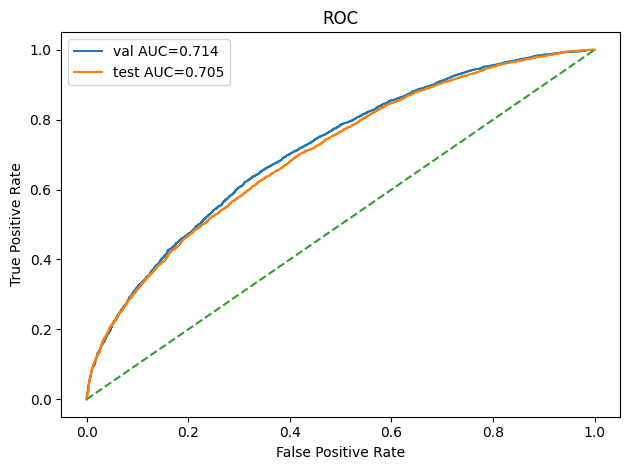

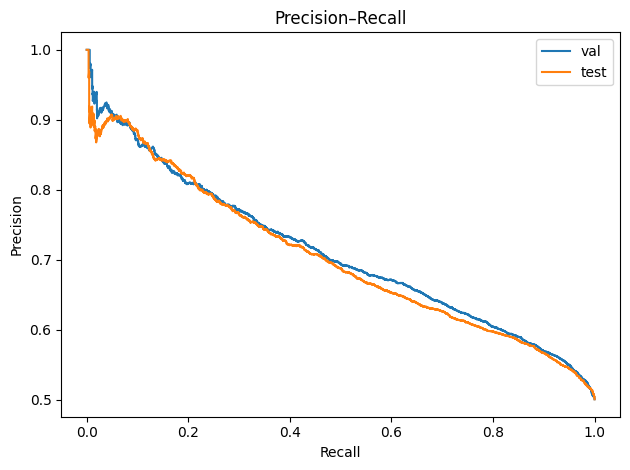

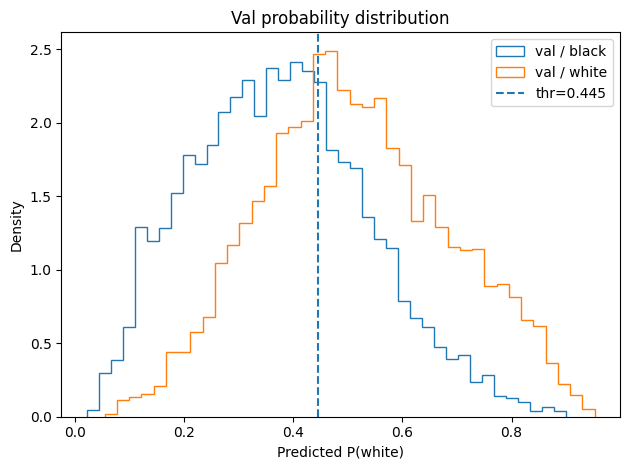

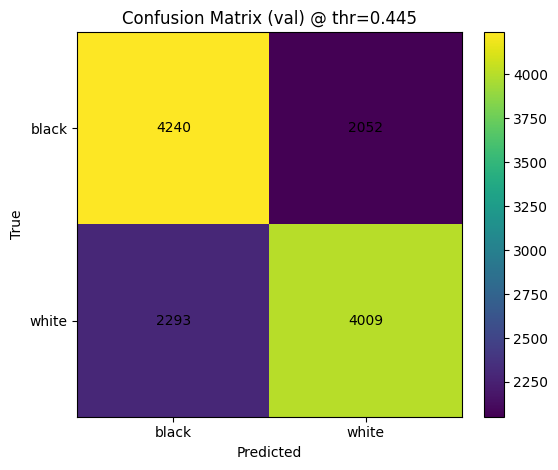

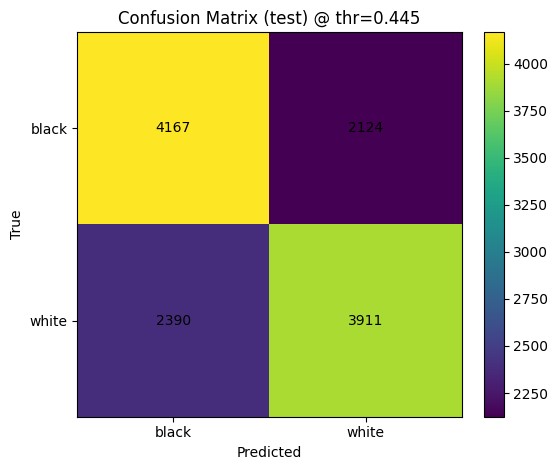

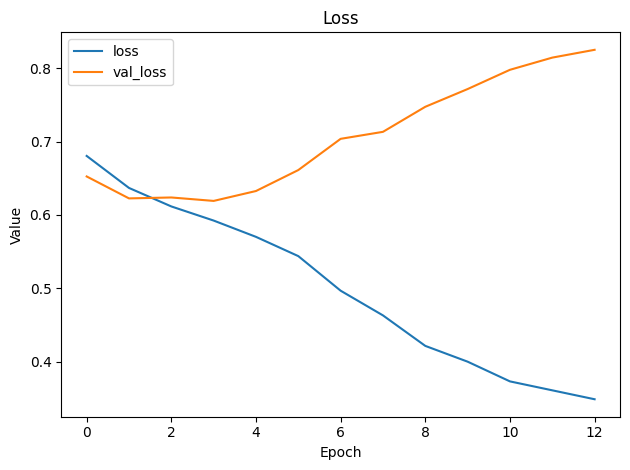

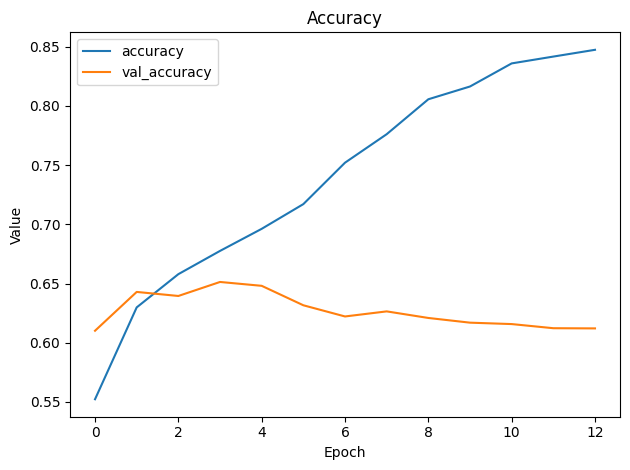

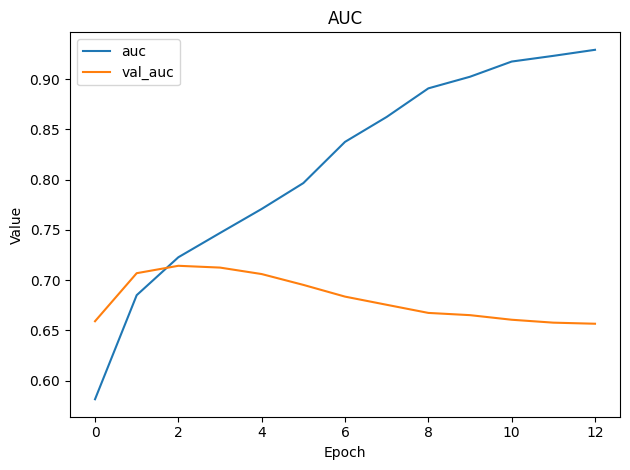

Saved plots and summary to: E:\Github Projects\chess-outcome-prediction\results


In [8]:
# ============================================================
# 4 · Final Evaluation & Plots (val + test)
# ============================================================
import os, json, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)

RESULTS_DIR = globals().get("RESULTS_DIR", "results")
os.makedirs(RESULTS_DIR, exist_ok=True)

# -------------------------
# 4.1 Predict probabilities
# -------------------------
val_prob  = model.predict(ds_val,  verbose=0).ravel()
test_prob = model.predict(ds_test, verbose=0).ravel()

# -------------------------
# 4.2 Pick threshold (by val accuracy; also show best by F1)
# -------------------------
def best_thr(y_true, prob, metric="acc"):
    grid = np.linspace(0.05, 0.95, 181)  # step=0.005
    best_t, best_s = 0.5, -1.0
    for t in grid:
        y_hat = (prob >= t).astype("int32")
        s = accuracy_score(y_true, y_hat) if metric=="acc" else f1_score(y_true, y_hat, average="macro")
        if s > best_s:
            best_t, best_s = t, s
    return float(best_t), float(best_s)

best_t_acc, best_acc = best_thr(y_val, val_prob, "acc")
best_t_f1,  best_f1  = best_thr(y_val, val_prob, "f1")

THR = best_t_acc  # use accuracy-optimal threshold for reports

# -------------------------
# 4.3 Reports & confusion matrices
# -------------------------
def eval_at(y_true, prob, name, thr):
    y_pred = (prob >= thr).astype("int32")
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    rep = classification_report(y_true, y_pred, target_names=CLASS_ORDER, zero_division=0)
    cm  = confusion_matrix(y_true, y_pred)
    print(f"[{name}] thr={thr:.3f}  acc={acc:.4f}  f1_macro={f1m:.4f}")
    print(rep)
    return acc, f1m, cm, y_pred

val_acc,  val_f1,  val_cm,  val_pred  = eval_at(y_val,  val_prob,  "val",  THR)
test_acc, test_f1, test_cm, test_pred = eval_at(y_test, test_prob, "test", THR)
print(f"Best thr by acc: {best_t_acc:.3f} (val acc={best_acc:.4f}) | by F1: {best_t_f1:.3f} (val f1={best_f1:.4f})")

# -------------------------
# 4.4 Plots (saved to results/)
# -------------------------
def plot_roc_pr():
    # ROC
    fpr_v, tpr_v, _ = roc_curve(y_val,  val_prob)
    fpr_t, tpr_t, _ = roc_curve(y_test, test_prob)
    auc_v, auc_t = auc(fpr_v, tpr_v), auc(fpr_t, tpr_t)

    plt.figure()
    plt.plot(fpr_v, tpr_v, label=f"val AUC={auc_v:.3f}")
    plt.plot(fpr_t, tpr_t, label=f"test AUC={auc_t:.3f}")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "roc.png"), dpi=160)
    plt.show()

    # PR
    p_v, r_v, _ = precision_recall_curve(y_val,  val_prob)
    p_t, r_t, _ = precision_recall_curve(y_test, test_prob)
    plt.figure()
    plt.plot(r_v, p_v, label="val")
    plt.plot(r_t, p_t, label="test")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "pr.png"), dpi=160)
    plt.show()

def plot_prob_hists():
    plt.figure()
    plt.hist(val_prob[y_val==0], bins=40, density=True, histtype="step", label="val / black")
    plt.hist(val_prob[y_val==1], bins=40, density=True, histtype="step", label="val / white")
    plt.axvline(THR, linestyle="--", label=f"thr={THR:.3f}")
    plt.xlabel("Predicted P(white)"); plt.ylabel("Density"); plt.title("Val probability distribution")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "val_prob_hist.png"), dpi=160)
    plt.show()

def plot_cm(cm, title, fname):
    plt.figure()
    im = plt.imshow(cm, aspect="equal")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    ticks = np.arange(len(CLASS_ORDER))
    plt.xticks(ticks, CLASS_ORDER); plt.yticks(ticks, CLASS_ORDER)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, int(cm[i, j]), ha="center", va="center")
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.tight_layout(); plt.savefig(os.path.join(RESULTS_DIR, fname), dpi=160)
    plt.show()

plot_roc_pr()
plot_prob_hists()
plot_cm(val_cm,  f"Confusion Matrix (val) @ thr={THR:.3f}",  "cm_val.png")
plot_cm(test_cm, f"Confusion Matrix (test) @ thr={THR:.3f}", "cm_test.png")

# -------------------------
# 4.5 Training curves (if available)
# -------------------------
if "history" in globals():
    H = history.history
    def curve(keys, title, fname):
        keys = [k for k in keys if k in H]
        if not keys: return
        plt.figure()
        for k in keys: plt.plot(H[k], label=k)
        plt.xlabel("Epoch"); plt.ylabel("Value"); plt.title(title)
        plt.legend(); plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_DIR, fname), dpi=160)
        plt.show()

    curve(["loss","val_loss"], "Loss", "loss_curves.png")
    curve(["accuracy","val_accuracy"], "Accuracy", "acc_curves.png")
    curve(["auc","val_auc"], "AUC", "auc_curves.png")

# -------------------------
# 4.6 Persist summary
# -------------------------
summary = {
    "threshold": THR,
    "val":  {"acc": val_acc,  "f1_macro": val_f1,  "cm": val_cm.tolist()},
    "test": {"acc": test_acc, "f1_macro": test_f1, "cm": test_cm.tolist()},
    "best_thr_by_acc": {"thr": best_t_acc, "val_acc": best_acc},
    "best_thr_by_f1":  {"thr": best_t_f1,  "val_f1":  best_f1},
}
with open(os.path.join(RESULTS_DIR, "final_summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("Saved plots and summary to:", RESULTS_DIR)